In [1]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

import spacy

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Rohan\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [6]:
#creating bigrams and trigrams models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram[bigram[data_words[0]]])


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return[bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ','VERB', 'ADV']):
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
        

In [8]:
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [9]:
# Create Dictionary and corpus

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [10]:
id2word[79]

'knowledge'

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.094*"space" + 0.044*"image" + 0.025*"display" + 0.021*"blue" + '
  '0.019*"earth" + 0.018*"print" + 0.017*"research" + 0.016*"project" + '
  '0.016*"satellite" + 0.015*"tank"'),
 (1,
  '0.050*"food" + 0.045*"bus" + 0.044*"specifically" + 0.036*"msg" + '
  '0.030*"eat" + 0.030*"motorcycle" + 0.025*"ride" + 0.018*"confuse" + '
  '0.016*"entry" + 0.016*"shift"'),
 (2,
  '0.029*"use" + 0.027*"system" + 0.021*"window" + 0.018*"card" + 0.016*"file" '
  '+ 0.016*"run" + 0.014*"program" + 0.013*"problem" + 0.012*"also" + '
  '0.011*"need"'),
 (3,
  '0.080*"game" + 0.076*"team" + 0.045*"play" + 0.045*"win" + 0.044*"player" + '
  '0.036*"hockey" + 0.030*"season" + 0.026*"contact" + 0.020*"goal" + '
  '0.020*"fan"'),
 (4,
  '0.112*"circuit" + 0.018*"stable" + 0.012*"cam" + 0.011*"chemistry" + '
  '0.010*"scout" + 0.007*"tran" + 0.006*"arabic" + 0.005*"randomly" + '
  '0.004*"axis" + 0.000*"tablet"'),
 (5,
  '0.129*"gun" + 0.052*"_" + 0.036*"weapon" + 0.025*"discipline" + '
  '0.023*"cri

In [14]:
#How to interpret this?

#Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

#It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

#The weights reflect how important a keyword is to that topic.

#Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

In [14]:
#Compute Model Perplexity and Coherence Score

#compute perplexity
print('\n perplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\n Coherence Score: ', coherence_lda)


 perplexity:  -14.792846256184669

 Coherence Score:  0.5025181203779839


In [15]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Rohan\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.361838 -0.070396       1        1  26.783375
13    -0.353335 -0.124223       2        1  22.667963
12    -0.296766 -0.075627       3        1  12.953279
2     -0.267226 -0.027502       4        1  10.931351
15    -0.205846  0.115209       5        1   8.618534
6     -0.094983  0.441079       6        1   5.042087
17    -0.138358 -0.079403       7        1   3.256530
3     -0.025691  0.031647       8        1   1.988041
0      0.026195  0.030529       9        1   1.898944
16     0.041435  0.018807      10        1   1.504171
5      0.130655 -0.026183      11        1   1.296322
8      0.137391 -0.009258      12        1   0.645862
18     0.145350 -0.015357      13        1   0.562712
1      0.153874 -0.020526      14        1   0.504953
11     0.170989 -0.025606      15        1   0.369607
9      0.178093 -0.028677      16        1   0.297865
19     0.182552 -0.031821      17        1   0.295467
10     0.176186 -0.028068      18        1   0.248325
4      0.199575 -0.036906      19        1   0.074328
14     0.201749 -0.037720      20        1   0.060280, topic_info=      Category          Freq                 Term         Total  loglift  \
term                                                                       
4146   Default  64902.000000                   ax  64902.000000  30.0000   
82     Default  24205.000000                  not  24205.000000  29.0000   
21     Default  18730.000000                 line  18730.000000  28.0000   
30     Default  16710.000000         organization  16710.000000  27.0000   
65     Default  15422.000000                   do  15422.000000  26.0000   
46     Default   7809.000000           university   7809.000000  25.0000   
322    Default  13744.000000                write  13744.000000  24.0000   
244    Default  11807.000000                   be  11807.000000  23.0000   
154    Default  17232.000000                would  17232.000000  22.0000   
3721   Default   4706.000000                  max   4706.000000  21.0000   
29     Default   6772.000000            nntp_post   6772.000000  20.0000   
16     Default   6320.000000                 host   6320.000000  19.0000   
55     Default  10769.000000              article  10769.000000  18.0000   
2191   Default   2698.000000                  gun   2698.000000  17.0000   
50     Default   5516.000000                 year   5516.000000  16.0000   
1911   Default   2883.000000                space   2883.000000  15.0000   
303    Default  10381.000000                  say  10381.000000  14.0000   
206    Default   5392.000000               system   5392.000000  13.0000   
18     Default  10702.000000                 know  10702.000000  12.0000   
317    Default   7222.000000                  use   7222.000000  11.0000   
271    Default   7960.000000                 good   7960.000000  10.0000   
2726   Default   2570.000000                 game   2570.000000   9.0000   
567    Default   2443.000000                 team   2443.000000   8.0000   
263    Default   1482.000000                drive   1482.000000   7.0000   
226    Default   8830.000000                   go   8830.000000   6.0000   
756    Default   2031.000000                  key   2031.000000   5.0000   
43     Default   3697.000000                thank   3697.000000   4.0000   
967    Default   2371.000000            christian   2371.000000   3.0000   
215    Default   3680.000000               window   3680.000000   2.0000   
147    Default   7793.000000                think   7793.000000   1.0000   
...        ...           ...                  ...           ...      ...   
1825   Topic20      9.239207        demonstration     10.356579   7.2998   
2434   Topic20      5.612237  bush_administration      6.729609   7.2324   
3616   Topic20      4.667922        qualification      5.785295   7.1993   
15273  Topic20      0.011483     

In [16]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:\\Users\\Rohan\\Desktop\\python\\masterthesis\\gensim\\mallet-2.0.8'})
mallet_path = 'C:\\Users\\Rohan\\Desktop\\python\\masterthesis\\gensim\\mallet-2.0.8\\bin\\mallet'
#mallet_path = 'mallet-2.0.8' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('line', 0.09264035683118395),
   ('organization', 0.08953747697081353),
   ('university', 0.07852225346649859),
   ('host', 0.061126733249297),
   ('nntp_post', 0.060447978279840976),
   ('reply', 0.01997478910113449),
   ('distribution_world', 0.011577620479007079),
   ('keyword', 0.011538834480752448),
   ('mail', 0.011150974498206147),
   ('advance', 0.009580141568893629)]),
 (19,
  [('ax', 0.8530286543344214),
   ('max', 0.06243017772941603),
   ('tm', 0.0023213638012332246),
   ('qax', 0.0020311933260790714),
   ('_', 0.0010155966630395357),
   ('mf', 0.0010155966630395357),
   ('giz', 0.0010155966630395357),
   ('ml', 0.0008124773304316286),
   ('wm_wm', 0.0007689517591585056),
   ('gq', 0.0007689517591585056)]),
 (7,
  [('line', 0.018603694562859922),
   ('write', 0.01396679380749383),
   ('organization', 0.01396679380749383),
   ('bike', 0.013106723506095281),
   ('time', 0.010638695684690749),
   ('article', 0.009797322563757385),
   ('make', 0.009442076134918855),
 

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

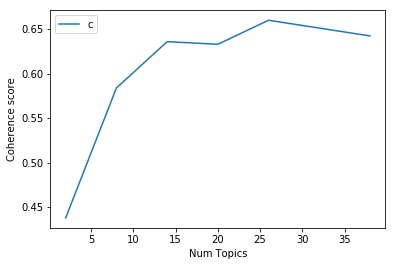

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))